In [23]:
#Relevant Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower,when,col
from pyspark.sql.types import DoubleType,IntegerType, StructType, StructField, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Imputer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import roc_curve, auc as sk_auc
import seaborn as sns
spark = (
    SparkSession
      .builder
      .appName("SpotifyPopularityPySpark")
      .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

# 1) Define the schema, due to problems when building the model
schema = StructType([
    StructField("song_name",     StringType(),  True),
    StructField("artists",       StringType(),  True),
    StructField("daily_rank",    IntegerType(), True),
    StructField("daily_movement",IntegerType(), True),
    StructField("weekly_movement",IntegerType(),True),
    StructField("country",       StringType(),  True),
    StructField("snapshot_date", StringType(),  True),
    StructField("popularity",    IntegerType(), True),
    StructField("is_explicit",   StringType(),  True),
    StructField("duration_ms",   IntegerType(), True),
    StructField("album_name",    StringType(),  True),
    StructField("album_release_date", StringType(), True),
    StructField("danceability",  DoubleType(),  True),
    StructField("energy",        DoubleType(),  True),
    StructField("key",           IntegerType(), True),
    StructField("loudness",      DoubleType(),  True),
    StructField("mode",          IntegerType(), True),
    StructField("speechiness",   DoubleType(),  True),
    StructField("acousticness",  DoubleType(),  True),
    StructField("instrumentalness", DoubleType(), True),
    StructField("liveness",      DoubleType(),  True),
    StructField("valence",       DoubleType(),  True),
    StructField("tempo",         DoubleType(),  True),
    StructField("time_signature",IntegerType(), True),
])
spotify_df = (
    spark.read
         .option("header", True)
         .option("sep", ",")
         .schema(schema)
         .csv("gs://edosa_spotify_project/cleaned/spotify_clean.csv")
)
spotify_df.printSchema()
spotify_df.show(5, truncate=False)

ImportError: cannot import name 'ICETransformer' from 'sklearn.inspection' (/opt/conda/miniconda3/lib/python3.11/site-packages/sklearn/inspection/__init__.py)

In [3]:
#dropping all irrelvant columns
drop = ["song_name","artists","daily_rank","daily_movement","weekly_movement",
    "country","snapshot_date","album_name","album_release_date"]
spotify_df = spotify_df.drop(*drop)
#check
spotify_df.printSchema()
spotify_df.show(5)

root
 |-- popularity: integer (nullable = true)
 |-- is_explicit: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: integer (nullable = true)

+----------+-----------+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|popularity|is_explicit|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+----------+-----------+-----------+------------+------+-

In [4]:
#mapping explicit
spotify_df = (
    spotify_df
    .withColumn(
        "explicit",
        when(lower(col("is_explicit")) == "true", 1)
       .otherwise(0)
    )
    .drop("is_explicit")
)
spotify_df.select("explicit").distinct().show()
spotify_df.printSchema()

+--------+
|explicit|
+--------+
|       1|
|       0|
+--------+

root
 |-- popularity: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- explicit: integer (nullable = false)



In [5]:
#checking to see if it worked
spotify_df.select("explicit").show(20)

+--------+
|explicit|
+--------+
|       0|
|       0|
|       0|
|       0|
|       0|
|       1|
|       1|
|       1|
|       0|
|       1|
|       1|
|       1|
|       1|
|       0|
|       1|
|       1|
|       1|
|       0|
|       0|
|       1|
+--------+
only showing top 20 rows



In [6]:
#mapping the target value
spotify_df = spotify_df.withColumn(
    "label",
    when(col("popularity") >= 70, 1).otherwise(0)
)

In [7]:
#build features, pipeline, train/test/predict, alongside classification report for logistic regression
feature_cols = [c for c in spotify_df.columns if c not in ("popularity","label")]
imputer = Imputer(
    inputCols=feature_cols,
    outputCols=feature_cols
).setStrategy("median")

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="raw_features"
)
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features"
)
lr = LogisticRegression(
    labelCol="label",
    featuresCol="features",
    maxIter=50,
    regParam=0.0,
    elasticNetParam=0.0
)
pipeline = Pipeline(stages=[imputer, assembler, scaler, lr])
train_df, test_df = spotify_df.randomSplit([0.8, 0.2], seed=42)
model    = pipeline.fit(train_df)
preds = model.transform(test_df) \
    .select("label", "prediction", "rawPrediction")
pdf = preds.select("label","prediction").toPandas()
print(classification_report(pdf["label"], pdf["prediction"], digits=3))
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
auc = auc_evaluator.evaluate(preds)
accuracy = acc_evaluator.evaluate(preds)

print(f"AUC:      {auc:.3f}")
print(f"Accuracy: {accuracy:.3f}")

25/05/16 15:55:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


              precision    recall  f1-score   support

           0      0.495     0.109     0.178    114670
           1      0.694     0.948     0.802    244762

    accuracy                          0.680    359432
   macro avg      0.595     0.528     0.490    359432
weighted avg      0.631     0.680     0.603    359432



AUC:      0.667
Accuracy: 0.680


In [8]:
#random forest
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=100,
    maxDepth=5,
    seed=42
)
pipeline = Pipeline(stages=[imputer, assembler, scaler, rf])
train_df, test_df = spotify_df.randomSplit([0.8,0.2], seed=42)
model = pipeline.fit(train_df)
preds = model.transform(test_df)
auc_eval = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
acc_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

auc = auc_eval.evaluate(preds)
acc = acc_eval.evaluate(preds)
print(f"AUC:      {auc:.3f}")
print(f"Accuracy: {acc:.3f}")

AUC:      0.766
Accuracy: 0.713


In [9]:
#classification report for rf
pdf = preds.select("label","prediction").toPandas()
print("\nClassification Report:\n")
print(classification_report(pdf["label"], pdf["prediction"], digits=3))


Classification Report:

              precision    recall  f1-score   support

           0      0.763     0.148     0.247    114670
           1      0.710     0.979     0.823    244762

    accuracy                          0.713    359432
   macro avg      0.737     0.563     0.535    359432
weighted avg      0.727     0.713     0.639    359432



In [10]:
#cross validator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
paramGrid = ParamGridBuilder().build()
cv = CrossValidator(
    estimator=pipeline,               
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    numFolds=5,                                           
)
cvModel = cv.fit(train_df)
print("Mean AUC across 5 folds:", cvModel.avgMetrics[0])
#best
best = cv


Mean AUC across 5 folds: 0.765230327596298


In [11]:
# Build best rf model
bestPipelineModel = cvModel.bestModel
predictions = bestPipelineModel.transform(test_df)
predictions.select("label", "prediction", "probability").show(5, truncate=False)
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
auc_eval = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
acc_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
best_auc = auc_eval.evaluate(predictions)
best_acc = acc_eval.evaluate(predictions)
print(f"Best model AUC:      {best_auc:.3f}")
print(f"Best model Accuracy: {best_acc:.3f}")
pdf = predictions.select("label", "prediction").toPandas()
from sklearn.metrics import classification_report
print(classification_report(pdf["label"], pdf["prediction"], digits=3))

+-----+----------+-------------------------------------+
|label|prediction|probability                          |
+-----+----------+-------------------------------------+
|0    |1.0       |[0.31485227883866,0.6851477211613399]|
|0    |1.0       |[0.31485227883866,0.6851477211613399]|
|0    |1.0       |[0.31485227883866,0.6851477211613399]|
|0    |1.0       |[0.31485227883866,0.6851477211613399]|
|0    |1.0       |[0.31485227883866,0.6851477211613399]|
+-----+----------+-------------------------------------+
only showing top 5 rows



Best model AUC:      0.766
Best model Accuracy: 0.713


              precision    recall  f1-score   support

           0      0.763     0.148     0.247    114670
           1      0.710     0.979     0.823    244762

    accuracy                          0.713    359432
   macro avg      0.737     0.563     0.535    359432
weighted avg      0.727     0.713     0.639    359432



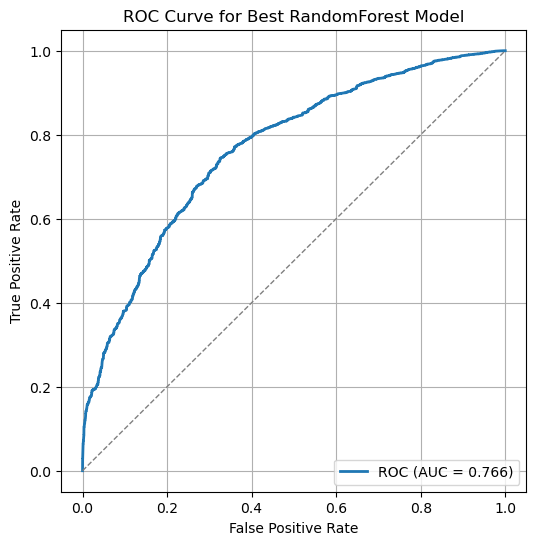

In [14]:
#Visualizations:ROC Curve
pdf = predictions.select("label", "probability").toPandas()

# 2) Extract P(1)
pdf["proba_1"] = pdf["probability"].apply(lambda v: float(v[1]))

# 3) Compute ROC curve + AUC
fpr, tpr, _ = roc_curve(pdf["label"], pdf["proba_1"])
roc_auc = sk_auc(fpr, tpr)

# 4) Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})", lw=2)
plt.plot([0, 1], [0, 1], "--", color="gray", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best RandomForest Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<Figure size 600x400 with 0 Axes>

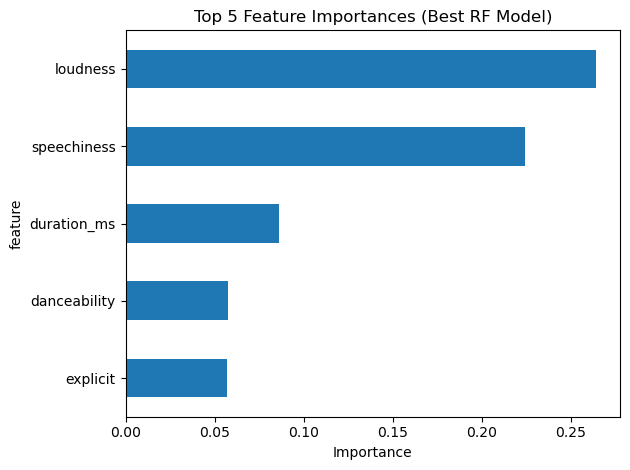

In [15]:
#Feature Importances
rf_model = bestPipelineModel.stages[-1]  
importances = rf_model.featureImportances
feat_list = feature_cols
feat_imp = list(zip(feat_list, importances.toArray()))
top5 = sorted(feat_imp, key=lambda x: x[1], reverse=True)[:5]
df_top5 = pd.DataFrame(top5, columns=["feature", "importance"])\
            .set_index("feature")
plt.figure(figsize=(6,4))
df_top5.sort_values("importance").plot.barh(legend=False)
plt.title("Top 5 Feature Importances (Best RF Model)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

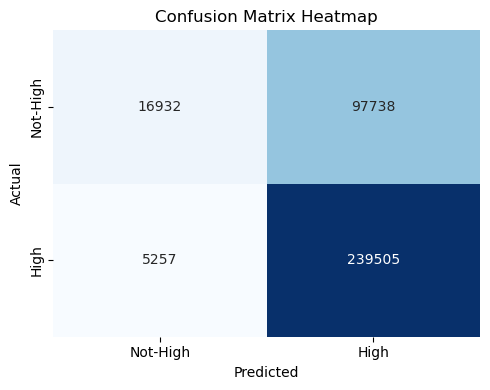

In [20]:
#Confusion Matrix
pdf = predictions.select("label", "prediction", "probability").toPandas()
cm = confusion_matrix(pdf["label"], pdf["prediction"])
labels = ["Not-High", "High"]
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()